## The goal of this notebook is to answer 3 kinds of questions: 

### - How have energy prices in the UK changed over the past decade?
### - How do changes in energy prices affect mobility?
### - How do changes in energy prices affect transportation costs?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib import rcParams
import matplotlib.dates as mdates

%matplotlib inline

In [2]:
# Some plotting settings
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Arial", "Tahoma"]

# Colors used to shade multi-lines
COLOR_SCALE = [
    "#7F3C8D",
    "#11A579",
    "#3969AC",
    "#F2B701",
    "#E73F74",
    "#80BA5A",
    "#E68310",
    "#7f7f7f",
]

### Load CPIH

In [3]:
# Define data dir
data_path = Path.cwd().parent / "data" / "raw"

# Find the first CPIH file in the data directory
cpih_files = list(data_path.glob("cpih*"))
if not cpih_files:
    raise FileNotFoundError("No CPIH files found in the data directory")
cpih_path = cpih_files[0]

# Load cpih time series
cpih = pd.read_csv(cpih_path)
cpih.head()


,v4_0,mmm-yy,Time,uk-only,Geography,cpih1dim1aggid,Aggregate
0,74.2,Feb-93,Feb-93,K02000001,United Kingdom,CP051,"05.1 Furniture, furnishings and carpets"
1,24.1,Feb-93,Feb-93,K02000001,United Kingdom,CP022,02.2 Tobacco
2,178.1,Feb-93,Feb-93,K02000001,United Kingdom,CP032,03.2 Footwear including repairs
3,101.5,Feb-93,Feb-93,K02000001,United Kingdom,CP071,07.1 Purchase of vehicles
4,41.0,Feb-93,Feb-93,K02000001,United Kingdom,CP0952,09.5.2 Newspapers and periodicals


### Load Transport Data

In [4]:
# Load Rail Passenger Journey by ticket type
rail_journey_ticket = pd.read_csv(
    data_path.joinpath("quarterly_rail_ticket_journey.csv")
)
rail_journey_ticket.head()


,Time period,Franchised ordinary ticket\nAdvance\n(million),Franchised ordinary ticket\nAnytime or Peak\n(million),Franchised ordinary ticket\nOff Peak\n(million),Franchised ordinary ticket\nOther\n(million)\n[note 5],Franchised ordinary ticket\nTotal\n(million)\n[note 2],Franchised Season ticket\n(million),Open access passenger journeys\n(million)\n[note 3],Total passenger journeys\n(million)\n[note 4]
0,Jul to Sep 2013,13.503565,84.907783,129.013020,3.856492,231.0,156.486430,1.911296,390.0
1,Oct to Dec 2013,12.677553,85.027822,125.355037,2.853913,226.0,174.625120,1.943971,402.0
2,Jan to Mar 2014,13.478331,82.077165,112.199018,3.364310,211.0,193.699051,1.886830,407.0
3,Apr to Jun 2014,14.679887,86.137312,126.810709,3.600569,231.0,159.309506,2.003221,393.0
4,Jul to Sep 2014,15.416574,90.427318,135.269606,3.799255,245.0,159.952194,1.983487,407.0


### Clean the data 

In [5]:
# Check for which column to use as a date column
if len((cpih["Time"] == cpih["mmm-yy"]).unique()) > 1:
    print(
        "'Time' and 'mmm-yy' are different. Better to inspect before making a decision."
    )
else:
    print("'Time' and 'mmm-yy' are identical. Pick one and delete the other.")

'Time' and 'mmm-yy' are identical. Pick one and delete the other.


In [6]:
# Drop columns
cpih_clean = cpih.drop(columns=["mmm-yy", "uk-only", "Geography"])
# Make 'date' column a datetime type
cpih_clean["Time"] = pd.to_datetime(cpih_clean["Time"], format="%b-%y")
# Change column names and sort the dataset
existing_col = cpih_clean.columns
new_col = ["cpih", "time", "category_code", "category_name"]

cpih_clean = (
    cpih_clean.rename(columns=dict(zip(existing_col, new_col)))
    .sort_values(by=["time", "category_code"])
    .reset_index(drop=True)
)


In [7]:
# Remove numbers from the category names (we already have that info in the category_code column)
cpih_clean["category_name"] = (
    cpih_clean["category_name"].str.replace(
        "\d+\.*\/*", "", regex=True).str.strip()
)


In [8]:
# Compute Month-on-Month and Year-on-Year rate
cpih_clean["MoM_cpih"] = cpih_clean.groupby(["category_name"])["cpih"].diff()
cpih_clean["YoY_cpih"] = cpih_clean.groupby(["category_name"])["cpih"].diff(12)

# cpih_clean[cpih_clean["category_name"]=="Overall Index"].tail(13)


In [9]:
cpih_clean.tail()


,cpih,time,category_code,category_name,MoM_cpih,YoY_cpih
52089,133.5,2023-07-01,CP1252,House contents insurance,0.7,6.2
52090,153.1,2023-07-01,CP1253,Health insurance,1.7,11.1
52091,187.4,2023-07-01,CP1254,Transport insurance,9.9,62.1
52092,90.3,2023-07-01,CP126,Financial services (nec),0.1,1.4
52093,99.8,2023-07-01,CP127,Other services (nec),-2.4,0.8


In [10]:
# Drop columns
rail_journey_ticket_clean = rail_journey_ticket.drop(columns="Time period")

# Change column names
existing_col = rail_journey_ticket_clean.columns
new_col = [
    "advance",
    "peak",
    "off-peak",
    "other",
    "ordinary_total",
    "season",
    "open_access",
    "total",
]

rail_journey_ticket_clean = rail_journey_ticket_clean.rename(
    columns=dict(zip(existing_col, new_col))
)

# Define date columns
start_date = "2013-07-1"
end_date = "2023-03-01"
date_range = pd.date_range(start_date, end_date, freq="QS")

# Add 'date' column as a datetime type
rail_journey_ticket_clean["quarter"] = pd.to_datetime(date_range, format="%Y-%b-%d")

# Sort by date (Quarter)
rail_journey_ticket_clean = rail_journey_ticket_clean.sort_values(
    by=["quarter"]
).reset_index(drop=True)

In [11]:
rail_journey_ticket_clean.head()

,advance,peak,off-peak,other,ordinary_total,season,open_access,total,quarter
0,13.503565,84.907783,129.013020,3.856492,231.0,156.486430,1.911296,390.0,2013-07-01
1,12.677553,85.027822,125.355037,2.853913,226.0,174.625120,1.943971,402.0,2013-10-01
2,13.478331,82.077165,112.199018,3.364310,211.0,193.699051,1.886830,407.0,2014-01-01
3,14.679887,86.137312,126.810709,3.600569,231.0,159.309506,2.003221,393.0,2014-04-01
4,15.416574,90.427318,135.269606,3.799255,245.0,159.952194,1.983487,407.0,2014-07-01


## EDA

### Define a bunch of useful functions for later

In [12]:
def get_min_max_values(data, x_col, y_col, round_values=True):
    """
    Get the minimum and maximum values for specified columns in a DataFrame.
    Useful for defining the x and y limits for a plot.

    Parameters:
    - data (pd.DataFrame): The DataFrame containing the data.
    - x_col (str): The name of the column for the x-values.
    - y_col (str): The name of the column for the y-values.
    - round_values (bool, optional): Whether to round the y-values. Default is True.

    Returns:
    - Tuple: A tuple containing:
        - (x_min, x_max): Minimum and maximum values for x_col.
        - (y_min, y_max): Minimum and maximum values for y_col.
    """
    # Input validation
    if x_col not in data.columns or y_col not in data.columns:
        raise ValueError(f"'{x_col}' or '{y_col}' not found in DataFrame columns.")

    if round_values and pd.api.types.is_numeric_dtype(data[x_col]):
        x_min, x_max = data[x_col].min().round(), data[x_col].max().round()
    else:
        # Handle datetime values differently (no rounding)
        x_min, x_max = data[x_col].min(), data[x_col].max()

    y_min, y_max = data[y_col].min().round(), data[y_col].max().round()

    return (x_min, x_max), (y_min, y_max)


def draw_background(
    ax,
    x_min,
    x_max,
    y_min,
    y_max,
    bg_color="#FFFFFF",
    line_color="#e8e8e8",
    zero_line_color="#999999",
    cross_zero=True,
):
    """
    Draw a background with horizontal lines on an Axes.

    Parameters:
    - ax (matplotlib.axes.Axes): The Axes to draw on.
    - x_min (float): Minimum value for the x-axis.
    - x_max (float): Maximum value for the x-axis.
    - y_min (float): Minimum value for the y-axis.
    - y_max (float): Maximum value for the y-axis.
    - bg_color (str, optional): Background color. Default is "#FFFFFF".
    - line_color (str, optional): Color of horizontal lines. Default is "#e8e8e8".
    - zero_line_color (str, optional): Color of the zero line if data crosses zero. Default is "#999999".
    - cross_zero (bool, optional): Whether to draw a darker horizontal line at y=0 if data crosses zero. Default is True.
    """
    # Background color
    ax.set_facecolor(bg_color)

    # Horizontal lines
    y_values = np.linspace(y_min, y_max, 9)
    ax.hlines(y=y_values, xmin=x_min, xmax=x_max, color=line_color, lw=0.6)

    # Check if data crosses zero
    if cross_zero and y_min <= 0 and y_max >= 0:
        ax.hlines(y=0, xmin=x_min, xmax=x_max, color=zero_line_color, lw=1)

    # Customize spines
    ax.spines[["left", "bottom"]].set_color(line_color)
    ax.spines[["right", "top"]].set_color("none")

### Show change in CPIH and cost of energy across time 

In [13]:
# Select a few CPIH categories of interest and select last decade
target_category = ["Overall Index", "Electricity", "Gas", "Liquid fuels"]
cpih_targets = cpih_clean[
    (cpih_clean["category_name"].isin(target_category))
    & (cpih_clean["time"] >= "2013-09-01")
]


Text(0, 0.5, 'Percentage change')

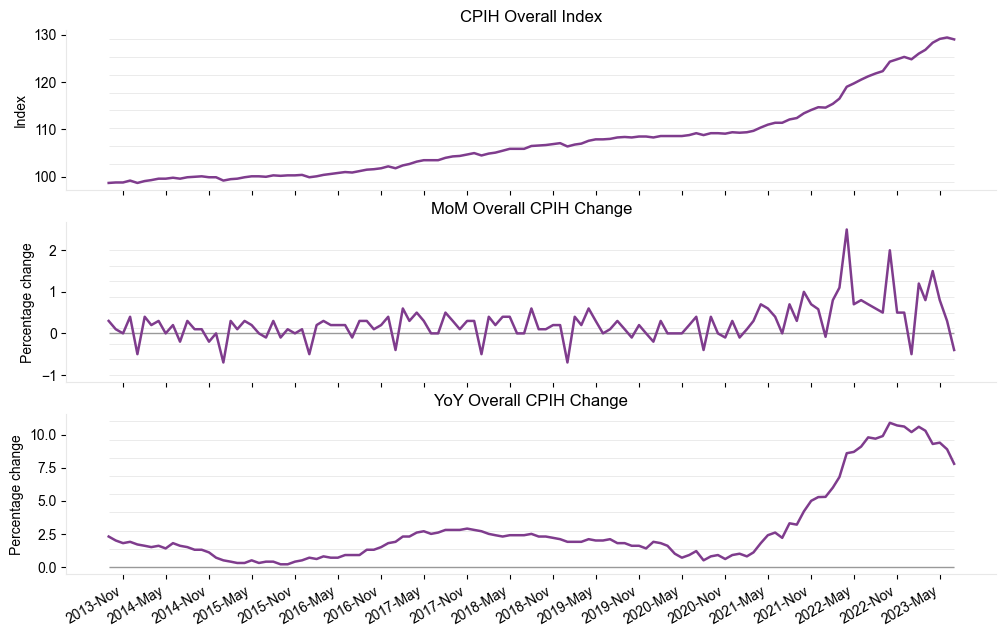

In [14]:
# Select CPIH Overall Index
data = cpih_targets[cpih_targets["category_name"] == "Overall Index"]

# Line plots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# Set special formatting for the dates on the x-axis
half_year_locator = mdates.MonthLocator(interval=6)
year_month_formatter = mdates.DateFormatter("%Y-%b")

# Loop across CPIH types
for ax, group in zip([ax1, ax2, ax3], ["cpih", "MoM_cpih", "YoY_cpih"]):
    # Get x and y limits for the selected category
    x_lim, y_lim = get_min_max_values(data, "time", group)
    # Prepare background
    draw_background(ax, x_lim[0], x_lim[1], y_lim[0], y_lim[1])
    # Get color
    color = COLOR_SCALE[0]
    # Plot
    ax.plot("time", group, color=color, lw=1.8, data=data)
    # Adjust the x-axis
    ax.xaxis.set_major_locator(half_year_locator)
    ax.xaxis.set_major_formatter(year_month_formatter)
    # Adjust x-ticks
    xticks = ax.xaxis.get_major_ticks()
    xticks[0].set_visible(False)
    xticks[-1].set_visible(False)

# Rotates and right aligns the x labels
fig.autofmt_xdate()
# Finishing touches
ax1.set_title("CPIH Overall Index")
ax1.set_ylabel("Index")

ax2.set_title("MoM Overall CPIH Change")
ax2.set_ylabel("Percentage change")

ax3.set_title("YoY Overall CPIH Change")
ax3.set_ylabel("Percentage change")


Text(0, 0.5, 'Percentage change')

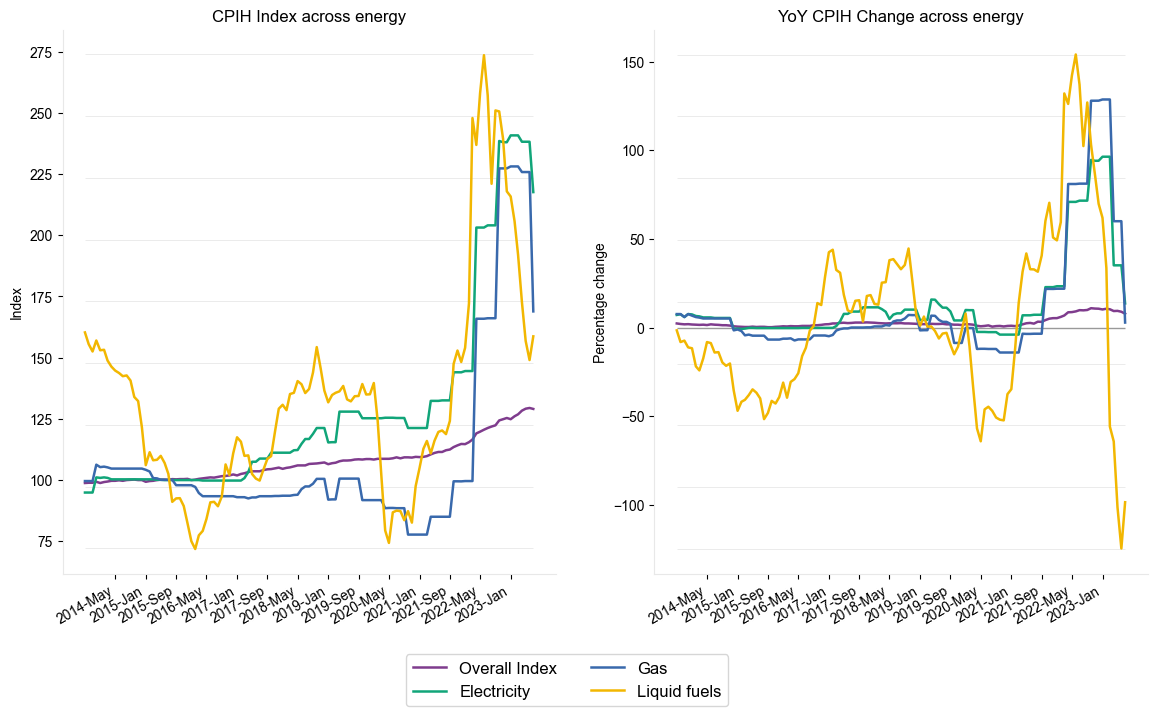

In [15]:
# Multi-line plots for the YoY change across categories
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))
# Set special formatting for the dates on the x-axis
eight_months_locator = mdates.MonthLocator(interval=8)
year_month_formatter = mdates.DateFormatter("%Y-%b")

for ax, y_value in zip([ax1, ax2], ["cpih", "YoY_cpih"]):
    # Get x and y limits for the target value
    x_lim, y_lim = get_min_max_values(cpih_targets, "time", y_value)
    # Prepare background
    draw_background(ax, x_lim[0], x_lim[1], y_lim[0], y_lim[1])
    # Loop across categories
    for idx, group in enumerate(target_category):
        tmp = cpih_targets[cpih_targets["category_name"] == group]
        color = COLOR_SCALE[idx]
        ax.plot("time", y_value, color=color, lw=1.8, data=tmp, label=group)

    # Adjust the x-axis
    ax.xaxis.set_major_locator(eight_months_locator)
    ax.xaxis.set_major_formatter(year_month_formatter)
    # Adjust x-ticks
    xticks = ax.xaxis.get_major_ticks()
    xticks[0].set_visible(False)
    xticks[-1].set_visible(False)

    # Rotates and right aligns the x labels
    fig.autofmt_xdate()

# Set the Legend
ax1.legend(
    bbox_to_anchor=(0.0, -0.25, 1.35, 0.102),
    ncol=2,
    borderaxespad=0,
    prop={"family": "Arial", "size": 12},
)

# Finishing touches
ax1.set_title("CPIH Index across energy")
ax1.set_ylabel("Index")

ax2.set_title("YoY CPIH Change across energy")
ax2.set_ylabel("Percentage change")

### Show change in Rail journeys across time

Text(0, 0.5, 'Count Millions')

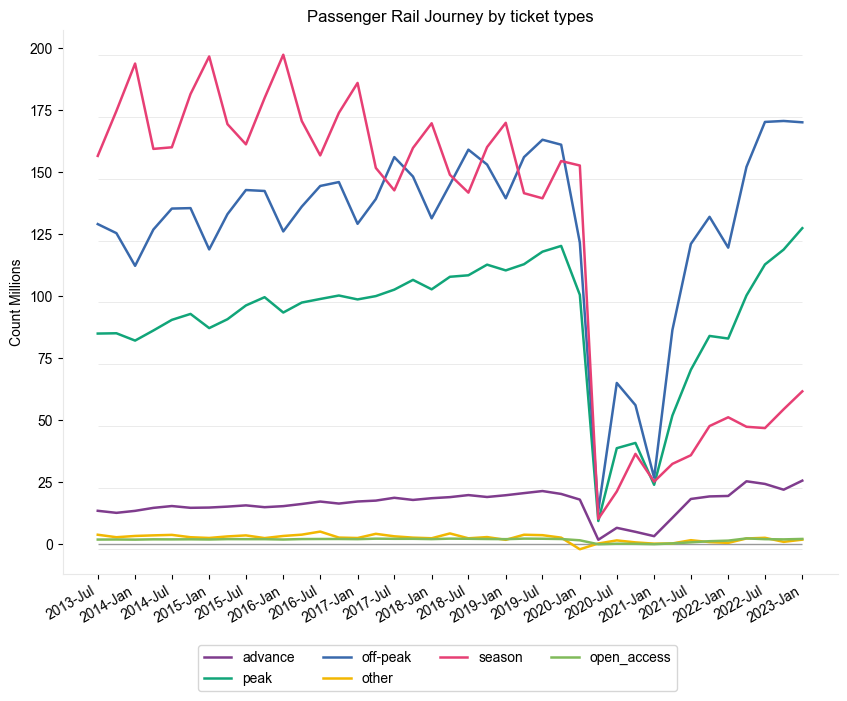

In [16]:
# Multi-line plots across ticket-types
fig, ax = plt.subplots(figsize=(10, 8))

# Set special formatting for the dates on the x-axis
biquarter_locator = mdates.MonthLocator(interval=6)
biquarter_formatter = mdates.DateFormatter("%Y-%b")

# Get x and y limits for the target value
x_lim, _ = get_min_max_values(rail_journey_ticket_clean, "quarter", "total")

# Since we will plot all values on the same plot we need to combine all col
all_values = (
    rail_journey_ticket_clean.select_dtypes(include="number")
    .drop(columns=["ordinary_total", "total"])
    .to_numpy()
    .ravel()
)
y_lim = (all_values.min().round(), all_values.max().round())

# Prepare background
draw_background(ax, x_lim[0], x_lim[1], y_lim[0], y_lim[1])

# Get ticket types, remove totals for now
ticket_types = rail_journey_ticket_clean.select_dtypes(
    include="number").columns
ticket_types = [
    ticket for ticket in ticket_types if ticket not in ["ordinary_total", "total"]
]
# Loop across ticket types
for idx, ticket in enumerate(ticket_types):
    tmp = rail_journey_ticket_clean[["quarter", ticket]]
    color = COLOR_SCALE[idx]
    ax.plot("quarter", ticket, color=color, lw=1.8, data=tmp, label=ticket)

# Adjust the x-axis
ax.xaxis.set_major_locator(biquarter_locator)
ax.xaxis.set_major_formatter(biquarter_formatter)

# Rotates and right aligns the x labels
fig.autofmt_xdate()

# Make room on below
fig.subplots_adjust(bottom=0.2)

# Set the Legend
ax.legend(
    loc="upper center",
    ncol=4,
    bbox_to_anchor=(0.5, 0.12),
    bbox_transform=fig.transFigure,
)

# Finishing touches
ax.set_title("Passenger Rail Journey by ticket types")
ax.set_ylabel("Count Millions")


### Report some summary statistics


In [17]:
# Create a function to determine change label
def get_change_label(value):
    if value > 0:
        return "increased"
    elif value < 0:
        return "decreased"
    else:
        return "stable"


months = cpih_targets["time"].dt.strftime("%b-%Y").unique()
latest_month = months[-1]
previous_month = months[-2]
previous_year = months[-13]

# Loop across categories
for group in target_category:
    tmp = cpih_targets[cpih_targets["category_name"] == group]
    latest_MoM = tmp.iloc[-1]["MoM_cpih"]
    latest_YoY = tmp.iloc[-1]["YoY_cpih"]

    # Determine MoM and YoY change labels
    MoM_change_label = get_change_label(latest_MoM)
    YoY_change_label = get_change_label(latest_YoY)

    # Print the results
    print(
        f"MoM {group} CPIH {MoM_change_label} in {latest_month} compared to {previous_month}: {latest_MoM:.2f}%"
    )
    print(
        f"YoY {group} CPIH {YoY_change_label} in {latest_month} compared to {previous_year}: {latest_YoY:.2f}%\n"
    )


MoM Overall Index CPIH decreased in Jul-2023 compared to Jun-2023: -0.40%
YoY Overall Index CPIH increased in Jul-2023 compared to Jul-2022: 7.80%

MoM Electricity CPIH decreased in Jul-2023 compared to Jun-2023: -20.60%
YoY Electricity CPIH increased in Jul-2023 compared to Jul-2022: 13.60%

MoM Gas CPIH decreased in Jul-2023 compared to Jun-2023: -57.00%
YoY Gas CPIH increased in Jul-2023 compared to Jul-2022: 2.80%

MoM Liquid fuels CPIH increased in Jul-2023 compared to Jun-2023: 9.70%
YoY Liquid fuels CPIH decreased in Jul-2023 compared to Jul-2022: -98.60%



In [18]:
# Get baseline values for March 2022
baseline_2022 = cpih_targets[cpih_targets["time"] == "2022-03-01"]

# Find the latest month and its values
last_month = cpih_targets["time"].max()
latest_values = cpih_targets[cpih_targets["time"] == last_month]
last_month_str = last_month.strftime("%b-%Y")

# Loop through target categories and print comparisons
for group, bsln, current in zip(
    target_category, baseline_2022["cpih"], latest_values["cpih"]
):
    print(
        f"{group} CPIH in {last_month_str} is {current:.2f}, and it was {bsln:.2f} in Mar-2022. A difference of {current-bsln:.2f} percentage points"
    )

Overall Index CPIH in Jul-2023 is 129.00, and it was 116.50 in Mar-2022. A difference of 12.50 percentage points
Electricity CPIH in Jul-2023 is 217.70, and it was 144.50 in Mar-2022. A difference of 73.20 percentage points
Gas CPIH in Jul-2023 is 168.90, and it was 99.50 in Mar-2022. A difference of 69.40 percentage points
Liquid fuels CPIH in Jul-2023 is 158.70, and it was 248.00 in Mar-2022. A difference of -89.30 percentage points


In [19]:
# Get a few timepoints of interest
latest_quarter = rail_journey_ticket_clean["quarter"].max()
previous_year = latest_quarter - pd.DateOffset(months=12)

latest_quarter = latest_quarter.strftime("%Y-%b")
previous_year = previous_year.year

# Compare current quarter with last year quarter
QoQ_change = rail_journey_ticket_clean.select_dtypes(include="number").diff(4)
# Extract also a Pre-Covid baseline
pre_covid_baseline = rail_journey_ticket_clean[
    rail_journey_ticket_clean["quarter"] == "2019-10-01"
]
# Loop across tickets
for ticket in ["advance", "peak", "off-peak", "season", "total"]:
    # Select value and determine label
    latest_QoQ = QoQ_change.iloc[-1][ticket]
    QoQ_change_label = get_change_label(latest_QoQ)

    covid_QoQ = (
        rail_journey_ticket_clean.iloc[-1][ticket] - pre_covid_baseline[ticket]
    ).iloc[0]
    covid_change_label = get_change_label(covid_QoQ)

    print(
        f"The number of {ticket} Rail Journeys {QoQ_change_label} by {latest_QoQ:.2f} millions in the Q starting in {latest_quarter} compared to the equivalent Q in {previous_year}."
    )
    print(
        f"The number of {ticket} Rail Journeys {covid_change_label} by {covid_QoQ:.2f} millions in the Q starting in {latest_quarter} compared to the last Q before Covid pandemic.\n"
    )


The number of advance Rail Journeys increased by 6.17 millions in the Q starting in 2023-Jan compared to the equivalent Q in 2022.
The number of advance Rail Journeys increased by 5.36 millions in the Q starting in 2023-Jan compared to the last Q before Covid pandemic.

The number of peak Rail Journeys increased by 44.47 millions in the Q starting in 2023-Jan compared to the equivalent Q in 2022.
The number of peak Rail Journeys increased by 7.16 millions in the Q starting in 2023-Jan compared to the last Q before Covid pandemic.

The number of off-peak Rail Journeys increased by 50.50 millions in the Q starting in 2023-Jan compared to the equivalent Q in 2022.
The number of off-peak Rail Journeys increased by 9.02 millions in the Q starting in 2023-Jan compared to the last Q before Covid pandemic.

The number of season Rail Journeys increased by 10.44 millions in the Q starting in 2023-Jan compared to the equivalent Q in 2022.
The number of season Rail Journeys decreased by -92.79 mil

## While annual inflation has been generally decreasing in recent periods, it consistently remains higher than it was before late 2022.

## Change in Rail journeys potentially masked by large fluctuations during COVID.

### Check impact on Transport across UK

In [20]:
# Set 'time' as the index of the DataFrame for pivoting and resampling
cpih_targets.set_index("time", inplace=True)

# Resample the DataFrame to quarterly frequency and calculate the mean for each quarter
cpih_quarterly = (
    cpih_targets.pivot(columns="category_name", values="cpih")
    .resample("QS")
    .mean()
    .reset_index()
)
# Remove unnecessary labels
cpih_quarterly.columns.name = None

cpih_quarterly.head()


,time,Electricity,Gas,Liquid fuels,Overall Index
0,2013-07-01,94.800000,99.500000,160.300000,98.700000
1,2013-10-01,96.866667,101.733333,155.000000,98.933333
2,2014-01-01,100.866667,105.233333,151.666667,99.033333
3,2014-04-01,100.200000,104.600000,144.900000,99.666667
4,2014-07-01,100.200000,104.600000,141.900000,99.833333


In [21]:
# As further adjustment let's filter according to the latest quarter in the Rail data
latest_quarter = rail_journey_ticket_clean["quarter"].max()
cpih_quarterly = cpih_quarterly[cpih_quarterly["time"] <= latest_quarter]

# Extract numerical columns from both datasets
cpih_numeric = cpih_quarterly.select_dtypes(include="number")
rail_numeric = rail_journey_ticket_clean.select_dtypes(include="number")

# Calculate the correlation between the numeric columns
correlation_matrix = pd.concat([cpih_numeric, rail_numeric], axis=1).corr(
    method="spearman"
)

# correlation_matrix.style.background_gradient(cmap="coolwarm")


In [22]:
# Identify the columns from cpih_numeric and rail_numeric
cpih_columns = cpih_numeric.columns
rail_columns = rail_numeric.columns

# Create a mask to specify which cells to show
mask = np.zeros_like(correlation_matrix)

# Set the mask to 1 for cells where at least one column is not from cpih_numeric or rail_numeric
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        col1 = correlation_matrix.columns[i]
        col2 = correlation_matrix.columns[j]
        if (col1 not in cpih_columns or col2 not in cpih_columns) and (
            col1 not in rail_columns or col2 not in rail_columns
        ):
            mask[i, j] = mask[j, i] = 1

# Apply the mask to the correlation matrix to hide internal comparisons
masked_correlation = np.ma.masked_where(mask == 0, correlation_matrix)

# Convert the masked array back to a DataFrame for display
masked_correlation = pd.DataFrame(
    masked_correlation,
    columns=correlation_matrix.columns,
    index=correlation_matrix.index,
)

# Show only the upper triangular part of the masked correlation matrix
masked_correlation = masked_correlation.where(
    np.triu(np.ones(masked_correlation.shape), k=1).astype(bool)
)

# Display the upper triangular part of the masked correlation matrix
masked_correlation = masked_correlation.dropna(
    how="all").dropna(axis=1, how="all")

# Show the correlation matrix
masked_correlation.style.format(precision=2).background_gradient(
    cmap="coolwarm", vmin=-1, vmax=1
)


,advance,peak,off-peak,other,ordinary_total,season,open_access,total
Electricity,0.53,0.20,0.17,-0.59,0.19,-0.77,-0.08,-0.40
Gas,0.34,0.32,0.43,0.32,0.40,0.26,0.29,0.10
Liquid fuels,0.53,0.32,0.35,-0.05,0.34,-0.15,0.15,-0.11
Overall Index,0.50,0.19,0.17,-0.65,0.20,-0.81,-0.08,-0.41


<Axes: xlabel='quarter'>

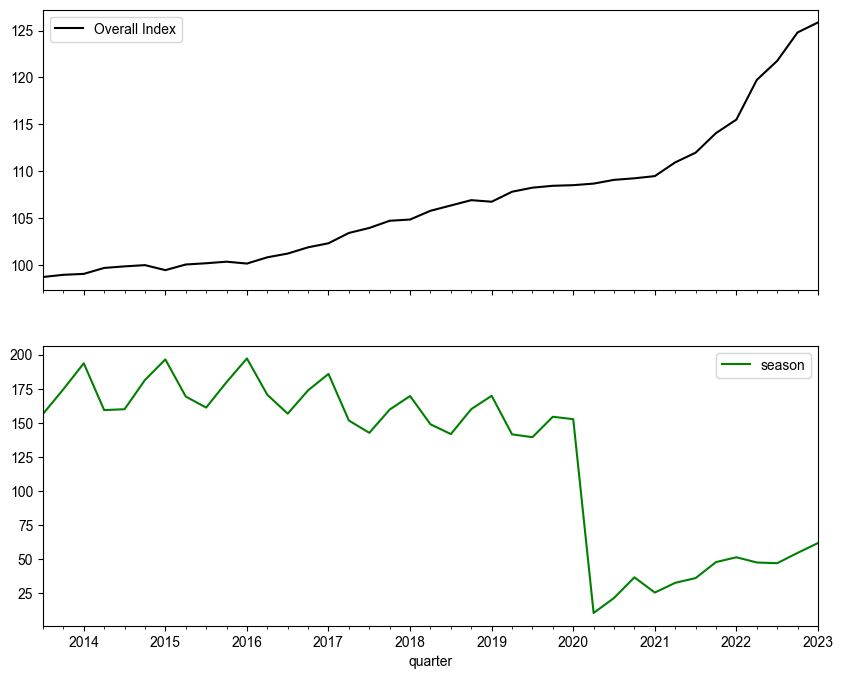

In [23]:
# Quick visualisation
concat_df = pd.concat([cpih_quarterly, rail_journey_ticket_clean], axis=1).drop(
    columns=["time"]
)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
concat_df.plot(x="quarter", y="Overall Index", color="k", ax=ax1)
concat_df.plot(x="quarter", y="season", color="g", ax=ax2)
